In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm


from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError

plt.rcParams['font.family'] = 'AppleGothic'

np.random.seed(42)

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [513]:
columns = {
    'realgdp': '실질GDP / Real GDP',
    'realcons': '실질 개인 소비 지출 / Real personal consumption expenditure',
    'realinv': '실질 국내 총 민간 투자 / Real domestic gross private investment',
    'realgovt': '실질 연방 소비 지출 및 투자 / Real Federal Consumer Spending and Investment',
    'realdpi': '실질 민간 가처분 소득 / Real private disposable income',
    'cpi': '분기 말 소비자물가지수 / Consumer Price Index at the end of the quarter',
    'm1': 'M1 명목 통화량 / M1 nominal money supply',
    'tbilrate': '3개월 만기 국채의 분기별 월평균 금리 / Quarterly average monthly interest rate on 3-month Treasury bonds',
    'unemp': '실업률 / Unemployment rate',
    'pop': '분기 말 총인구 / Total population at the end of the quarter',
    'infl': '인플레이션율 / Inflation rate',
    'realint': '실질 이자율 / Real interest rate'
}

In [17]:
macro_econ_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


In [ ]:
fig, (ax1, ax2, ax3, ax4 , ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = plt.subplots(12, 1, sharex=True, figsize=(24,34))

macro_econ_data.realgdp.plot( ax = ax1)
macro_econ_data.realcons.plot( ax = ax2)
macro_econ_data.realinv.plot( ax = ax3)
macro_econ_data.realgovt.plot( ax = ax4)
macro_econ_data.realdpi.plot( ax = ax5)
macro_econ_data.cpi.plot( ax = ax6)
macro_econ_data.m1.plot( ax = ax7)
macro_econ_data.tbilrate.plot( ax = ax8)
macro_econ_data.unemp.plot( ax = ax9)
macro_econ_data['pop'].plot( ax = ax10)
macro_econ_data.infl.plot( ax = ax11)
macro_econ_data.realint.plot( ax = ax12)

ax1.set_title(columns['realgdp'])
ax2.set_title(columns['realcons'])
ax3.set_title(columns['realinv'])
ax4.set_title(columns['realgovt'])
ax5.set_title(columns['realdpi'])
ax6.set_title(columns['cpi'])
ax7.set_title(columns['m1'])
ax8.set_title(columns['tbilrate'])
ax9.set_title(columns['unemp'])
ax10.set_title(columns['pop'])
ax11.set_title(columns['infl'])
ax12.set_title(columns['realint'])

plt.xticks( np.arange(0, 204, 4),  np.arange(1959, 2010, 1)  )
fig.autofmt_xdate()
plt.tight_layout()

In [516]:
target = macro_econ_data.iloc[:, [2] ]
exog = macro_econ_data.iloc[:, list(range( 3,14, 1)) ]

In [160]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [161]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4


parameters_list = list(product(p, q, P, Q))

target_train = target[:202]
exog_train = exog[:202]


In [133]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 0)",1782.015266
1,"(2, 2, 1, 0)",1782.435862
2,"(2, 3, 0, 0)",1782.506869
3,"(2, 2, 0, 1)",1783.200430
4,"(3, 3, 0, 0)",1783.468721
...,...,...
251,"(0, 0, 0, 0)",1798.350890
252,"(0, 2, 0, 0)",1799.144947
253,"(1, 0, 0, 0)",1800.322377
254,"(0, 1, 0, 0)",1800.329862


In [162]:
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  202
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -875.008
Date:                Sat, 17 Aug 2024   AIC                           1782.015
Time:                        08:58:14   BIC                           1834.868
Sample:                             0   HQIC                          1803.402
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9483      0.055     17.196      0.000       0.840       1.056
realinv        0.9486      0.040     23.551      0.000       0.870       1.028
realgovt       0.7003      0.138      5.078      0.0

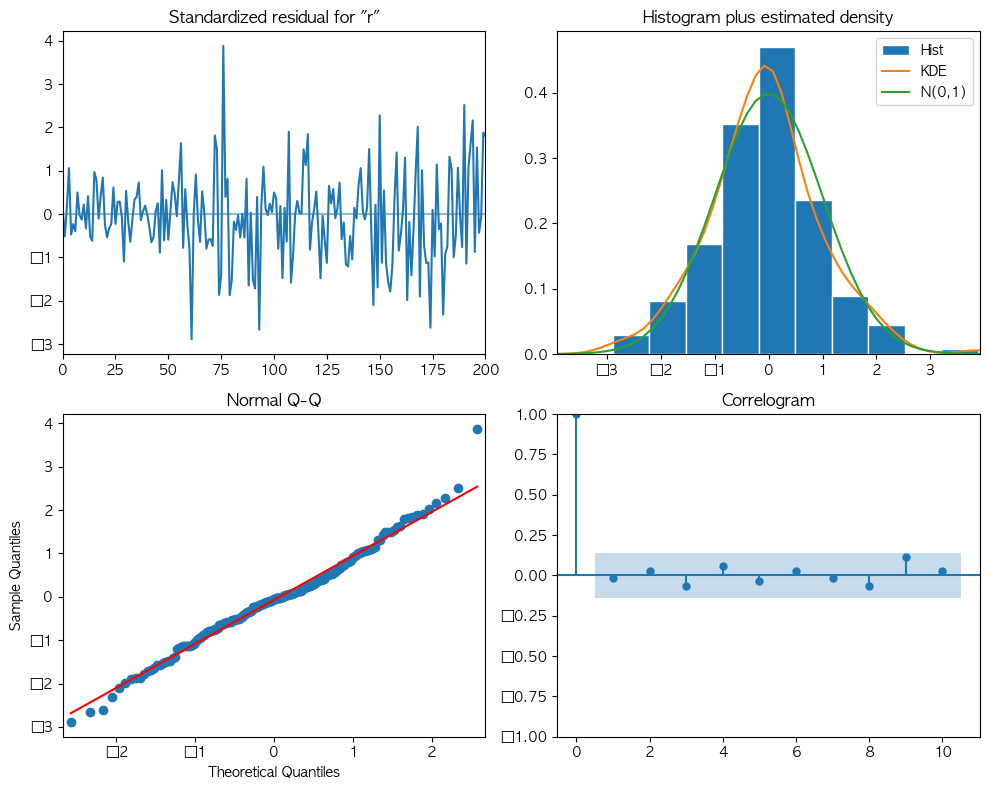

In [163]:
best_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [178]:
residuals = best_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.004905   0.944164
2   0.028559   0.985822
3   0.049713   0.997096
4   0.115343   0.998400
5   0.119038   0.999751
6   0.123578   0.999962
7   0.127041   0.999995
8   0.185729   0.999997
9   0.195306   0.999999
10  0.196102   1.000000


In [541]:
def getPred(target: Union[pd.Series, list], exog:Union[pd.Series, list], start:int, end:int)-> pd.DataFrame:
    pred_df = pd.DataFrame({'actual': target.loc[start:end, 'realgdp' ].values })
    pred_df['pred_last_value'] = target.loc[start-1:end-1, 'realgdp' ].values 
    
    pred_SARIMAX = []
    for i in range(start, end+1, 1):
        model = SARIMAX(target[:i], exog[:i], order=(2,1,2), seasonal_order=(0,0,0,4), simple_differencing=False).fit(disp=False)
        pred_SARIMAX.append( model.get_prediction( i, i,   exog= exog[i:i+1]   ).predicted_mean.item() )
    
    pred_df['pred_SARIMAX'] = pred_SARIMAX
    
    return pred_df
    

In [542]:
pred_df = getPred(target=target, exog=exog, start=196, end=202)
pred_df.index = list(range(196,203,1))
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13386.599624
197,13415.266,13366.865,13349.606191
198,13324.600,13415.266,13329.209918
199,13141.920,13324.600,13119.984455
200,12925.410,13141.920,12874.245112
201,12901.504,12925.410,12858.481259
202,12990.341,12901.504,13046.183632


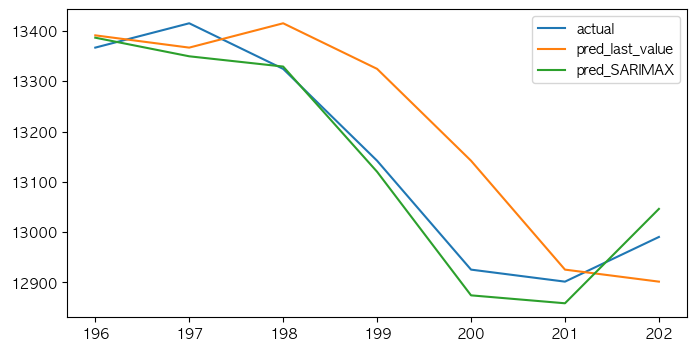

In [543]:
ax = pred_df.plot( figsize=(8,4),  layout='constrained')

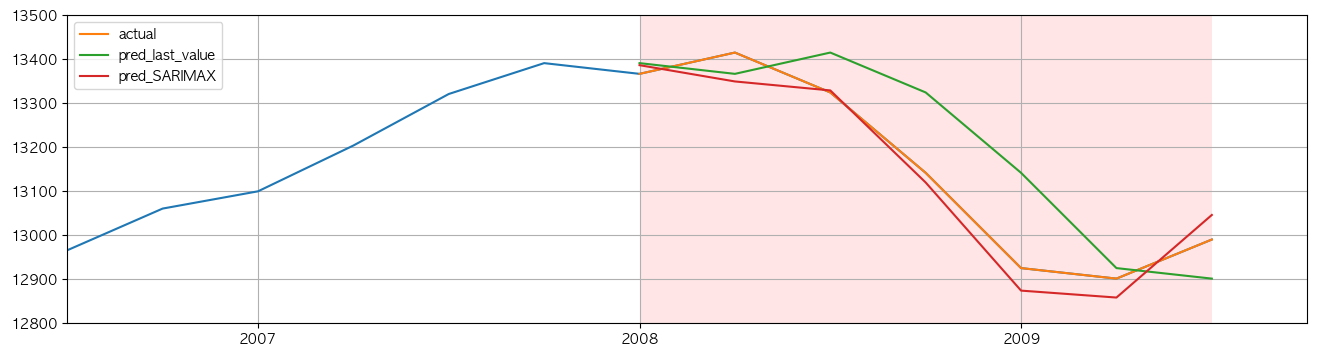

In [544]:
ax = target.realgdp.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(196, 202, facecolor='red', alpha=0.1)
ax.set_xticks( np.arange(0, 204, 4),  np.arange(1959, 2010, 1)  )
ax.set_xlim(190, 203)
ax.set_ylim(12800, 13500)
pred_df.plot( ax = ax)
ax.grid()
plt.show()

In [545]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_last_value = torch.FloatTensor( pred_df['pred_last_value'].values)
pred_SARIMAX = torch.FloatTensor( pred_df['pred_SARIMAX'].values)
actual = torch.FloatTensor(pred_df['actual'].values)


mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_last_value, actual).item()
mapes['mape_SARIMAX'] = mean_abs_percentage_error( pred_SARIMAX, actual ).item()
mapes

{'mape_naive_seasonal': 0.0073684826493263245,
 'mape_SARIMAX': 0.0028539744671434164}

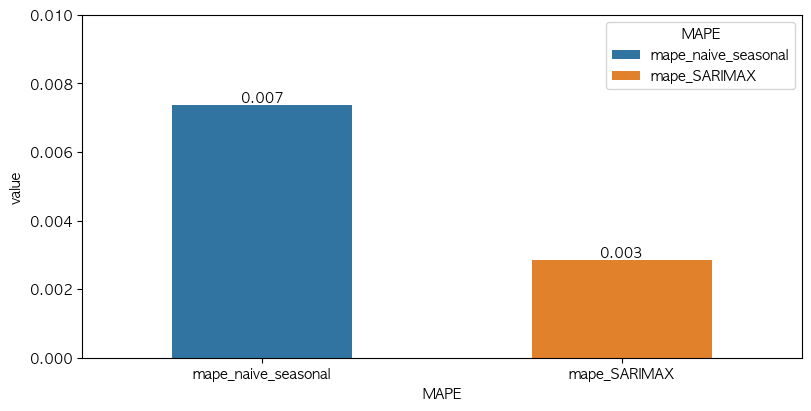

In [546]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.01)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.3f',  fontsize=10)

In [547]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_last_value = torch.FloatTensor( pred_df['pred_last_value'].values)
pred_SARIMAX = torch.FloatTensor( pred_df['pred_SARIMAX'].values)
actual = torch.FloatTensor(pred_df['actual'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_last_value, actual ).item()
maes['mae_SARIMA'] = mean_absolute_error( pred_SARIMAX, actual ).item()
maes

{'mae_naive_seasonal': 96.48326110839844, 'mae_SARIMA': 37.42424774169922}

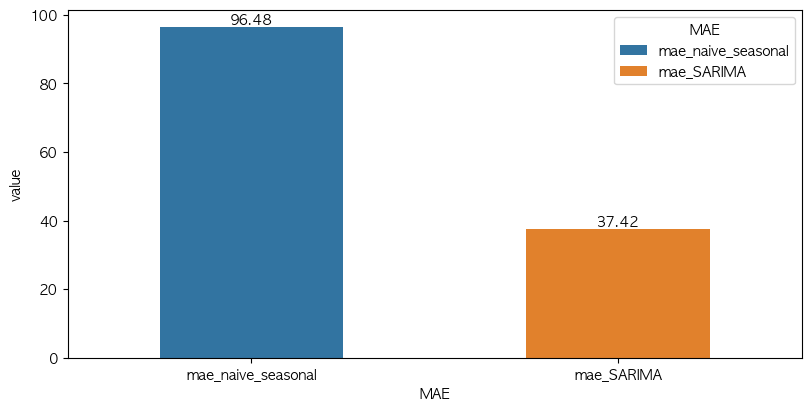

In [548]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)